<a href="https://colab.research.google.com/github/sakai1250/mysite/blob/master/200442066_%E5%9D%82%E4%BA%95%E6%B3%B0%E5%90%BE_%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# /content/drive/MyDrive/fish_images/fish
# /content/drive/MyDrive/fish_images/goldfish

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# https://venoda.hatenablog.com/entry/2020/10/11/221117 より改変
#                                   T. Mukai   2021.05.06
#  分類画像やそのフォルダを変えるときには，#change とある行を修正する
import os
from PIL import Image  # 画像処理ライブラリPillow

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models # pretrained model

import cv2                          # mean,stdの算出
import pandas as pd
import numpy as np                  # gragh
import matplotlib.pyplot as plt
%matplotlib inline
import time



# 学習データ、検証データへの分割
def make_filepath_list():
    """
    学習データ、検証データそれぞれのファイルへのパスを格納したリストを返す
    
    Returns
    -------
    train_file_list: list
        学習データファイルへのパスを格納したリスト
    valid_file_list: list
        検証データファイルへのパスを格納したリスト
    """
    train_file_list = []
    valid_file_list = []

    imagedir = '/content/drive/MyDrive/fish_images/'

    for top_dir in os.listdir(imagedir):
        file_dir = os.path.join(imagedir, top_dir)
        file_list = os.listdir(file_dir)

        # 学習データ40,検証データ10とする
        num_data = len(file_list)
        num_split = int(num_data - 10)

        # 以下で'\\'を'/'にreplaceしているのはWindowsでのpath出力に対応するため
        train_file_list += [os.path.join(imagedir, top_dir, file).replace('\\', '/') for file in file_list[:num_split]]
        valid_file_list += [os.path.join(imagedir, top_dir, file).replace('\\', '/') for file in file_list[num_split:]]
    
    return train_file_list, valid_file_list

# 前処理クラス
class ImageTransform(object):
    """
    入力画像の前処理クラス
    画像のサイズをリサイズする
    
    Attributes
    ----------
    resize: int
        リサイズ先の画像の大きさ
    mean: (R, G, B)
        各色チャンネルの平均値
    std: (R, G, B)
        各色チャンネルの標準偏差
    """
    def __init__(self, resize, mean, std):
        # 辞書型でMethodを定義
        self.data_trasnform = {
            'train': transforms.Compose([
                # データオーグメンテーション
                transforms.RandomHorizontalFlip(),
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ]),
            'valid': transforms.Compose([
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_trasnform[phase](img)
    
# Datasetクラス
class DogDataset(data.Dataset):
    """
    魚のDataseクラス。
    PyTorchのDatasetクラスを継承させる。
    
    Attrbutes
    ---------
    file_list: list
        画像のファイルパスを格納したリスト
    classes: list
        魚のラベル名
    transform: object
        前処理クラスのインスタンス
    phase: 'train' or 'valid'
        学習か検証化を設定
    """
    def __init__(self, file_list, classes, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.classes = classes
        self.phase = phase
    
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        前処理した画像データのTensor形式のデータとラベルを取得
        """
        # 指定したindexの画像を読み込む
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')
        
        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)
        
        # 画像ラベルをファイル名から抜き出す
        label = self.file_list[index].split('/')[5][:] # '/'で分けた5番目
       
        # ラベル名を数値に変換
        label = self.classes.index(label)
        
        return img_transformed, label
    


In [116]:
# 画素値の平均、標準偏差を算出
# https://qiita.com/ZESSU/items/40b8bb2cd179371df6ac

idir_1 = '/content/drive/MyDrive/fish_images/goldfish/'
idir_2 = '/content/drive/MyDrive/fish_images/fish/'

num_photo = 50
bgr_1 = np.zeros((num_photo,3))
bgr_2 = np.zeros((num_photo,3))

# idir_1 = '/content/drive/MyDrive/fish_images/goldfish/'
for k in range(num_photo): 
    if k < 9:
      img = cv2.imread(idir_1 + "0000" + str(k+1) + '.jpg')
      print(idir_1 + "0000" + str(k+1) + '.jpg')
    else:
      img = cv2.imread(idir_1 + "000" + str(k+1) + '.jpg')
      print(idir_1 + "000" + str(k+1) + '.jpg')
    
    h, w, c = img.shape #height, width, channnel

    #初期化
    l=0
    b_ave=0; g_ave=0; r_ave=0

    for i in range(h):
        for j in range(w):
            #画素値[0,0,0]（Black）を除外してピクセルの和とbgrの画素値の合計を計算する
            if(img[i,j,0] != 0 or img[i,j,1] != 0 or img[i,j,2] != 0 ):
                l+=1    #対象となるピクセル数を計算する
                #対象となるピクセルの画素値の和を計算する
                b_ave=b_ave+img[i,j,0]
                g_ave=g_ave+img[i,j,1]
                r_ave=r_ave+img[i,j,2]

    #画素値合計をピクセル数で除することでRGBの画素値の平均値を求める
    b_ave=b_ave/l
    g_ave=g_ave/l
    r_ave=r_ave/l

    bgr_1[k]=np.array([b_ave, g_ave, r_ave])
    print(bgr_1[k])

_mean = bgr_1.mean(axis=0)
_std = bgr_1.std(axis=0)

mean_1 = (_mean / 255) # 0~k+1までのBGRのmean,std / 255 == normalizationのmean(),std()
std_1 = (_std/ 255)


# idir_2 = '/content/drive/MyDrive/fish_images/fish/'
for k in range(num_photo): 

    if k < 9:
      img = cv2.imread(idir_1 + "0000" + str(k+1) + '.jpg')
      print(idir_2 + "0000" + str(k+1) + '.jpg')
    else:
      img = cv2.imread(idir_1 + "000" + str(k+1) + '.jpg')
      print(idir_2 + "000" + str(k+1) + '.jpg')
    
    h, w, c = img.shape #height, width, channnel

    #初期化
    l=0
    b_ave=0; g_ave=0; r_ave=0

    for i in range(h):
        for j in range(w):
            #画素値[0,0,0]（Black）を除外してピクセルの和とbgrの画素値の合計を計算する
            if(img[i,j,0] != 0 or img[i,j,1] != 0 or img[i,j,2] != 0 ):
                l+=1    #対象となるピクセル数を計算する
                #対象となるピクセルの画素値の和を計算する
                b_ave=b_ave+img[i,j,0]
                g_ave=g_ave+img[i,j,1]
                r_ave=r_ave+img[i,j,2]

    #画素値合計をピクセル数で除することでRGBの画素値の平均値を求める
    b_ave=b_ave/l
    g_ave=g_ave/l
    r_ave=r_ave/l

    bgr_2[k]=np.array([b_ave, g_ave, r_ave])
    print(bgr_2[k])
_mean = bgr_2.mean(axis=0)
_std = bgr_2.std(axis=0)

mean_2 = (_mean / 255) # 0~k+1までのBGRのmean,std / 255 == normalizationのmean(),std()
std_2 = (_std/ 255)


mean = (mean_1 + mean_2) / 2
std = (std_1 + std_2) / 2

mean = np.round(mean, 3)
std = np.round(std, 3)

mean = mean[::-1] # BGR,RGB変換
print(mean)
std = std[::-1]
print(std)

/content/drive/MyDrive/fish_images/goldfish/00001.jpg
[224.76326772 237.25230467 250.02361052]
/content/drive/MyDrive/fish_images/goldfish/00002.jpg
[ 74.24259575  94.3199395  101.75222627]
/content/drive/MyDrive/fish_images/goldfish/00003.jpg
[154.90578277 169.59373598 195.01198257]
/content/drive/MyDrive/fish_images/goldfish/00004.jpg
[134.27977038  75.00315978  85.04503044]
/content/drive/MyDrive/fish_images/goldfish/00005.jpg
[214.06645339 231.87304688 251.71738281]
/content/drive/MyDrive/fish_images/goldfish/00006.jpg
[189.50264978  68.36414344  60.54020439]
/content/drive/MyDrive/fish_images/goldfish/00007.jpg
[ 91.32081543 124.46546808 170.51657306]
/content/drive/MyDrive/fish_images/goldfish/00008.jpg
[123.58830853 147.29330058 173.63059909]
/content/drive/MyDrive/fish_images/goldfish/00009.jpg
[187.10436884 214.35110947 238.65510355]
/content/drive/MyDrive/fish_images/goldfish/00010.jpg
[47.2025974  46.63546225 51.62183479]
/content/drive/MyDrive/fish_images/goldfish/00011.jpg

device: cuda:0 



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
-------------
train Loss: 0.0843 Acc: 0.0125
train Loss: 0.0251 Acc: 0.0875
train Loss: 0.0122 Acc: 0.2000
train Loss: 0.0690 Acc: 0.2500
train Loss: 0.0127 Acc: 0.3375


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0205 Acc: 0.4125
train Loss: 0.0038 Acc: 0.5250
train Loss: 0.0283 Acc: 0.6000
valid Loss: 0.2781 Acc: 0.5500

Elapsed time: 6.259 sec
Epoch 2/5
-------------
train Loss: 0.0125 Acc: 0.1000
train Loss: 0.0401 Acc: 0.1750
train Loss: 0.0286 Acc: 0.2500
train Loss: 0.0137 Acc: 0.3375
train Loss: 0.0232 Acc: 0.4125
train Loss: 0.0105 Acc: 0.5250
train Loss: 0.0148 Acc: 0.6000
train Loss: 0.0128 Acc: 0.6875
valid Loss: 0.0318 Acc: 0.9000

Elapsed time: 11.855 sec
Epoch 3/5
-------------
train Loss: 0.0044 Acc: 0.1125
train Loss: 0.0028 Acc: 0.2250
train Loss: 0.0006 Acc: 0.3500
train Loss: 0.0001 Acc: 0.4750
train Loss: 0.0133 Acc: 0.5875
train Loss: 0.0002 Acc: 0.7125
train Loss: 0.0041 Acc: 0.8250
train Loss: 0.0014 Acc: 0.9500
valid Loss: 0.0236 Acc: 0.9000

Elapsed time: 17.599 sec
Epoch 4/5
-------------
train Loss: 0.0020 Acc: 0.1125
train Loss: 0.0008 Acc: 0.2375
train Loss: 0.0001 Acc: 0.3625
train Loss: 0.0020 Acc: 0.4750
train Loss: 0.0010 Acc: 0.6000
train Loss: 0.

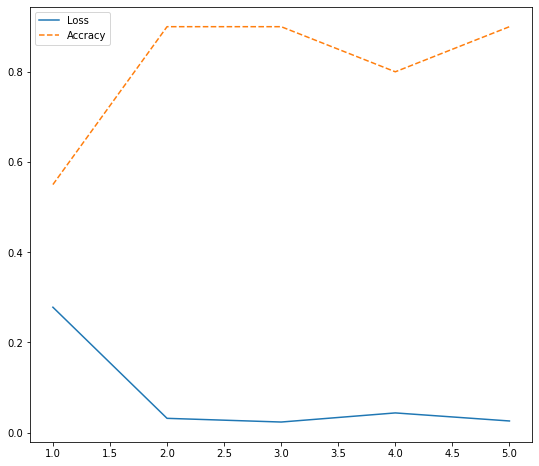

In [117]:
time_start = time.time()

#再現性を保つためにseedを固定
seed = 11
#random.seed(seed)
#np.random.seed(seed)  
torch.manual_seed(seed) 

# 各種パラメータの用意
# クラス名
myclasses = [
    'fish',  'goldfish',
]

# リサイズ先の画像サイズ
resize = 300

mean = tuple(mean) # (0.549 0.494 0.44)
std = tuple(std)  # (0.262 0.239 0.246)

# バッチサイズの指定
batch_size = 10  

# エポック数
num_epochs = 5

# GPU使用を試みる
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device,'\n')

# 2. 前処理
# 学習データ、検証データのファイルパスを格納したリストを取得する
train_file_list, valid_file_list = make_filepath_list()

# 3. Datasetの作成
train_dataset = DogDataset(
    file_list=train_file_list, classes=myclasses,
    transform=ImageTransform(resize, mean, std),
    phase='train'
)

valid_dataset = DogDataset(
    file_list=valid_file_list, classes=myclasses,
    transform=ImageTransform(resize, mean, std),
    phase='valid'
)

# 4. DataLoaderの作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False)

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 5. ネットワークの定義

net = models.alexnet(pretrained = True) # net = Net()
net.fc = nn.Linear(4096, 2)
net = net.to(device)                    # net = net.to(device)

# 6. 損失関数の定義
criterion = nn.CrossEntropyLoss()
# 7. 最適化手法の定義
optimizer = optim.SGD(net.parameters(), lr=0.005) 

# 8. 学習・検証


epoch_losses = np.empty(0, dtype=float)

epoch_accs = np.empty(0, dtype=float)

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch + 1, num_epochs))
  print('-------------')

  for phase in ['train', 'valid']:
    if phase == 'train':
        # 学習モードに設定
        net.train()
    else:
        # 訓練モードに設定
        net.eval()
        
    # epochの損失和
    epoch_loss = 0.0
    # epochの正解数
    epoch_corrects = 0.0
    
    for inputs, labels in dataloaders_dict[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # optimizerを初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
            
            outputs = net(inputs)
            
            # 損失を計算
            loss = criterion(outputs, labels)
            
            # ラベルを予測
            _, preds = torch.max(outputs, 1)[1]
            
            # 訓練時は逆伝搬の計算
            if phase == 'train':
                # 逆伝搬の計算
                loss.backward()
                
                # パラメータ更新
                optimizer.step()
                
            # イテレーション結果の計算
            # lossの合計を更新
            # PyTorchの仕様上各バッチ内での平均のlossが計算される。
            # データ数を掛けることで平均から合計に変換をしている。
            # 損失和は「全データの損失/データ数」で計算されるため、
            # 平均のままだと損失和を求めることができないため。

            epoch_loss += loss.item()
            
            # 正解数の合計を更新
            epoch_corrects += torch.sum(preds == labels.data)


            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            # 一時的保存
            _epoch_loss = epoch_loss
            _epoch_acc = epoch_acc.item()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
  
  # 1 epoch
  epoch_losses = np.append(epoch_losses, _epoch_loss)
  epoch_accs = np.append(epoch_accs, _epoch_acc)

  time_end = time.time()
  print('\nElapsed time: {:.3f} sec'.format(time_end - time_start))
  
# 30 epoch 
x = np.arange(1, num_epochs + 1, 1)
plt.figure(figsize=(9,8))
plt.plot(x, epoch_losses, label = "Loss")
plt.plot(x, epoch_accs, linestyle="--", label = "Accracy")
plt.legend()
plt.show()

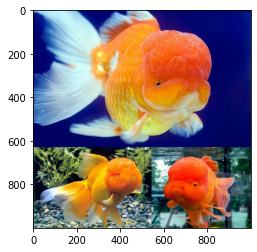

tensor([[ 9.2603e+00,  1.9440e+01,  4.7712e-01, -2.7245e+00, -1.6731e+00,
          9.8087e-01,  2.9679e-01,  1.6898e+00,  1.8526e+00, -2.5546e+00,
         -8.2906e-01,  2.5110e-01,  3.8901e+00, -1.7090e+00,  2.5512e+00,
         -5.5878e-01,  2.8771e+00, -5.1886e-01, -1.6537e+00,  3.5597e-01,
         -1.3329e+00, -3.3346e+00, -2.3822e+00,  1.7562e+00, -2.1194e+00,
         -1.7525e+00,  1.2717e+00,  1.7436e+00,  4.1494e-02,  4.5766e+00,
          4.1724e-01,  7.9740e+00,  4.1783e+00, -2.0865e-01, -6.1738e-01,
         -7.4796e-01, -5.0994e-01,  1.3376e+00,  3.5473e+00,  4.8177e-01,
          8.5868e-01,  1.3046e+00, -9.8402e-01, -7.8724e-01,  1.0283e+00,
         -5.1652e+00,  1.6475e+00,  5.7458e-01, -1.9731e+00, -1.6399e-01,
         -1.1668e+00,  1.2054e-01, -1.0324e+00,  1.3423e+00,  3.6714e-01,
         -1.9165e-01,  1.0977e+00, -2.1184e+00,  7.7451e-01,  1.2243e+00,
          1.2416e+00,  2.7046e+00,  5.3110e+00,  2.0989e+00, -3.1683e+00,
         -6.2088e-01, -3.0439e-01, -1.

In [122]:
# 動作確認
img = Image.open('/content/drive/MyDrive/fish_images/goldfish/00029.jpg') 

transform=ImageTransform(resize, mean, std)
img_valid = transform(img, 'train')
plt.imshow(img)
plt.show()

net.eval()
img_valid = img_valid.unsqueeze(0).to(device)
out = net(img_valid)

 # ラベルを求める
_, preds = torch.max(out, 1)
print(out)
print('Predicted label:', myclasses[preds.item()])